In [370]:
import mpfit3 as mpfit #https://code.google.com/archive/p/astrolibpy/downloads
import pandas as pd
import numpy as np
from astropy.io import fits
import orbital #install orbitalpy
import pickle
import matplotlib.pyplot as plt

earth=pd.read_csv('earth.csv',dtype='d')
year=365.25
d=fits.open('S1_detectedBinaries_detection_table.fits')
dd=d[1].data
d.close()

def makeorbit(t,p,dec,isprimary):
    a=np.where(isprimary==2)[0]
    b=np.where(isprimary==3)[0]
    per=t/p[6]*2*np.pi+p[7]
    
    th=np.zeros(len(t)+len(b),dtype='d')
    rad=np.zeros(len(t)+len(b),dtype='d')
    for i in range(len(rad)):
        while per[i]>2*np.pi: per[i]=per[i]-2*np.pi
        try:
            th[i]=orbital.utilities.true_anomaly_from_mean(p[5],per[i])
            rad[i]=orbital.utilities.orbit_radius(1.,p[5],th[i])
        except:
            pass
    
    
    if len(a)>0: th[a]=th[a]+np.pi
    if len(b)>0:
        c=b+len(b)
        th[c]=th[b]+np.pi
        r[c]=r[b]
    
    x1=rad*p[9]*(np.cos(th+p[8])*np.sin(p[12])-np.sin(th+p[8])*np.cos(p[12])*np.cos(p[11]))/np.cos(np.radians(dec))
    y1=rad*p[9]*(np.sin(th+p[8])*np.sin(p[12])*np.cos(p[11])+np.cos(th+p[8])*np.cos(p[12]))
    
    if len(a)>0:
        x1[a]=x1[a]/p[10]
        y1[a]=y1[a]/p[10]
    if len(b)>0:
        x1[b]=x1[b]-x1[c]/p[10]
        y1[b]=x1[b]-y1[c]/p[10]
        x1=x1[range(len(t))]
        y1=y1[range(len(t))]
        
    return(x1,y1)

def fitfunc(p, y=None, err=None, fa=None,fb=None,t=None,isprimary=None,fjac=None):
    #p[0] - parallax
    #p[1:2] - proper motion of the system
    #p[3:4] - center of the system
    #p[5] - eccentricity
    #p[6] - period
    #p[7] - mean anomaly of the first observation
    #p[8] - longitude of periastron
    #p[9] - semimajor axes
    #p[10] - mass ratio
    #p[11] - inclination
    #p[12] - Longitude of the ascending node
    #p[13:14] - acceleration
    
    coord1 = t*np.cos(np.radians(y[:,1]))*p[1]+fa*p[0]+p[3]+(t**2)*np.cos(np.radians(y[:,1]))*p[13]/2.
    coord2 = t*p[2]+fb*p[0]+p[4]+(t**2)*p[14]/2.
    
    x1,y1=makeorbit(t,p,y[:,1],isprimary)
    r1=(y[:,0] - coord1-x1)/err[:,0]
    d1=(y[:,1] - coord2-y1)/err[:,1]
    
    status=0
    return([status,np.append(r1,d1)])

def makemodel(p,start,flag):
    t=(earth['date'].values-start)
    dec=p[4]+p[2]*t+p[14]*(t**2)/2.
    ra=p[3]+(p[1]*np.cos(np.radians(dec)))*t+(p[13]*np.cos(np.radians(dec)))*(t**2)/2
    x1,y1=makeorbit(t,p,dec,np.zeros(len(ra))+flag)
    fa=((earth['ex']*np.sin(np.radians(ra))-earth['ey']*np.cos(np.radians(ra)))/(np.cos(np.radians(dec)))).values
    fb=(earth['ex']*np.cos(np.radians(ra))*np.sin(np.radians(dec))+earth['ey']*np.sin(np.radians(ra))*np.sin(np.radians(dec))-earth['ez']*np.cos(np.radians(dec))).values
    ra=ra+fa*p[0]+x1
    dec=dec+fb*p[0]+y1
    return(ra,dec)

def loaddata(i,j=None,k=None,skipepoch=None,fixdec=False):
    ii=np.where(dd['ra'][i]>0)[0]
    ii=ii[np.argsort(dd['date'][i][ii])]
    ra_d=dd['ra'][i][ii]
    dec_d=dd['dec'][i][ii]
    re=dd['re'][i][ii]/3600
    de=dd['de'][i][ii]/3600
    date=dd['date'][i][ii]
    x=dd['x'][i][ii]
    y=dd['y'][i][ii]
    z=dd['z'][i][ii]
    isprimary=np.zeros(len(ii))+1
    if j !=None:
        jj=np.where(dd['ra'][j]>0)[0]
        jj=jj[np.argsort(dd['date'][j][jj])]
        ra_d=np.append(ra_d,dd['ra'][j][jj])
        dec_d=np.append(dec_d,dd['dec'][j][jj])
        re=np.append(re,dd['re'][j][jj]/3600)
        de=np.append(de,dd['de'][j][jj]/3600)
        date=np.append(date,dd['date'][j][jj])
        x=np.append(x,dd['x'][j][jj])
        y=np.append(y,dd['y'][j][jj])
        z=np.append(z,dd['z'][j][jj])
        isprimary=np.append(isprimary,np.zeros(len(jj))+2)
        
    if fixdec:
        offdec=dec_d-np.round(dec_d)
        dec_d=dec_d-offdec*2
        
        
    #add a prescription for the relative astrometry data in terms of their ra&dec positional offset e.g.
    ##readcol,'DoAr51.ir',irdate,irrho,irrhoe,irtheta,irthetae,format='d,d,d,d,d'
    #x=-irrho*np.cos(np.radians(irtheta+90))/1e3/3600
    #y=irrho*np.sin(np.radians(irtheta+90))/1e3/3600
    #xe=-irrhoe*np.cos(np.radians(irtheta+90))/1e3/3600+irrho*np.sin(np.radians(irtheta+90))/1e3/3600*(np.radians(irthetae))
    #ye=irrhoe*sin(np.radians(irtheta+90))/1e3/3600+irrho*np.cos(np.radians(irtheta+90))/1e3/3600*(np.radians(irthetae))
    #x and y are added to ra_d and dec_d, xe and ye are added to re and de; add date, xyz do not matter, can be any arbitrary value
    #set isprimary=3 for all relative epochs
        
    fa=(x*np.sin(np.radians(ra_d))-y*np.cos(np.radians(ra_d)))/(np.cos(np.radians(dec_d)))
    fb=x*np.cos(np.radians(ra_d))*np.sin(np.radians(dec_d))+y*np.sin(np.radians(ra_d)
                            )*np.sin(np.radians(dec_d))-z*np.cos(np.radians(dec_d))
    
    
    data={'ra_d':ra_d,'dec_d':dec_d,'re':re,'de':de,'date':date,'x':x,'y':y,'z':z,'fa':fa,'fb':fb,'isprimary':isprimary}
    if skipepoch !=None:
        ep=list(range(len(ra_d)))
        for skip in skipepoch: ep.remove(skip)
        data={'ra_d':ra_d[ep],'dec_d':dec_d[ep],'re':re[ep],'de':de[ep],'date':date[ep],'x':x[ep],'y':y[ep],'z':z[ep],'fa':fa[ep],'fb':fb[ep],'isprimary':isprimary[ep]}

    return(data)

def rungrid(data,acceleration=False,ran=1000,startperiod=1,stopperiod=20,startecc=0.,stopecc=0.99,savepath=None,silent=False,ratio=1.5):
    
    t=data['date']-data['date'][0]
    
    yvals=np.append(np.reshape(data['ra_d'],[len(t),1]),np.reshape(data['dec_d'],[len(t),1]),1)
    errvals=np.append(np.reshape(data['re'],[len(t),1]),np.reshape(data['de'],[len(t),1]),1)
    args = {'fa':data['fa'],'fb':data['fb'],'t':t,'isprimary':data['isprimary'], 'y':yvals, 'err':errvals}
    
    parinfo = [{'value':0., 'fixed':0, 'limited':[0,0], 'limits':[0.,0.]} for i in range(15)]
        
    #parinfo[5]['fixed'] = 1
    parinfo[5]['limited'] = [1,1]
    parinfo[5]['limits']  = [0.0,0.99]
    parinfo[7]['limited'] = [1,1]
    parinfo[7]['limits']  = [0.0,2*np.pi]
    parinfo[8]['limited'] = [1,1]
    parinfo[8]['limits']  = [0.0,2*np.pi]
    parinfo[9]['limited'] = [1,0]
    parinfo[9]['limits']  = [0.0,0.0]
    parinfo[10]['limited'] = [1,1]
    parinfo[10]['limits']  = [0.1,10.0]
    if len(np.where(data['isprimary']>1)[0])==0: parinfo[10]['fixed']=1
    parinfo[12]['limited']=[1,1]
    parinfo[12]['limits']=[0,np.pi]
    if not acceleration:
        parinfo[13]['fixed']=1
        parinfo[14]['fixed']=1
        
    
    num=ran
    ksi=np.empty(num)
    params=np.empty([15,num],dtype='d')
    perr=np.empty([15,num])
        
    i=0
    
    
    lp=15
    if not acceleration: lp=lp-2
    if len(np.where(data['isprimary']>1)[0])==0: lp=lp-1
    dof=len(t)*2-lp-1
    periods=np.random.uniform(low=startperiod,high=stopperiod,size=ran)
    eccs=np.random.uniform(low=startecc,high=stopecc,size=ran)
    starts=np.random.uniform(low=0,high=360,size=ran)
    angles=np.random.uniform(low=0,high=360,size=ran)
    for i in range(ran):
        if (not silent) & (i % 100 ==0): print(i,ran)
        period=periods[i]
        ecc=eccs[i]
        start=starts[i]
        angle=angles[i]
        mupi=[2.5*1e-3/3600,0.,0.,data['ra_d'][0],data['dec_d'][0],ecc,period*year,
                          np.radians(start),np.radians(angle),0.,ratio,np.pi/2,np.pi/2,0.,0.]
        m = mpfit.mpfit( fitfunc, mupi, functkw=args,parinfo=parinfo,quiet=1)
        ksi[i]=m.fnorm/lp
        params[:,i]=m.params
        perr[:,i]=m.perror
        i=i+1
    for i in range(15): perr[i]=perr[i]*np.sqrt(ksi)
    bestfit={'ksi':ksi,'params':params,'perr':perr}
    if savepath != None: pickle.dump(bestfit,open(savepath,"wb" ))
    return(bestfit)

def plotbest(data,bestfit):
    best=np.min(bestfit['ksi'])
    l=np.where(bestfit['ksi']==best)[0]
    fig,ax = plt.subplots(figsize=(10,10))
    
    a=np.where(data['isprimary']==1)[0]
    plt.scatter((data['ra_d'][a]-data['ra_d'][0])*1000*3600,(data['dec_d'][a]-data['dec_d'][0])*1000*3600,c='blue')
    if len(np.where(data['isprimary']>1)[0])!=0:
        b=np.where(data['isprimary']==2)[0]
        plt.scatter((data['ra_d'][b]-data['ra_d'][0])*1000*3600,(data['dec_d'][b]-data['dec_d'][0])*1000*3600,c='red')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().invert_xaxis()
    
    t=np.where((earth['date']>=np.min(data['date'])-100) & (earth['date']<=np.max(data['date'])+100))[0]
    params=bestfit['params'][:,l]
    ra,dec=makemodel(params,np.min(data['date']),1)
    plt.plot((ra[t]-data['ra_d'][0])*1000*3600,(dec[t]-data['dec_d'][0])*1000*3600,c='blue')
    for k in a:
        s=np.where(np.abs(earth['date']-data['date'][k])<=0.5)[0][0]
        plt.scatter((ra[s]-data['ra_d'][0])*1000*3600,(dec[s]-data['dec_d'][0])*1000*3600,edgecolors='blue',marker='d',facecolors='none')
        plt.plot([(ra[s]-data['ra_d'][0])*1000*3600,(data['ra_d'][k]-data['ra_d'][0])*1000*3600],[(dec[s]-data['dec_d'][0])*1000*3600,(data['dec_d'][k]-data['dec_d'][0])*1000*3600],color='blue')
    if len(np.where(data['isprimary']>1)[0])!=0:
        ra1,dec1=makemodel(params,np.min(data['date']),2)
        plt.plot((ra1[t]-data['ra_d'][0])*1000*3600,(dec1[t]-data['dec_d'][0])*1000*3600,c='red')
        for k in b:
            s=np.where(np.abs(earth['date']-data['date'][k])<=0.5)[0][0]
            plt.scatter((ra1[s]-data['ra_d'][0])*1000*3600,(dec1[s]-data['dec_d'][0])*1000*3600,edgecolors='red',marker='d',facecolors='none')
            plt.plot([(ra1[s]-data['ra_d'][0])*1000*3600,(data['ra_d'][k]-data['ra_d'][0])*1000*3600],[(dec1[s]-data['dec_d'][0])*1000*3600,(data['dec_d'][k]-data['dec_d'][0])*1000*3600],color='red')
    plt.show()
    return


def outputsummaryfromfit(bestfit,upto=1.1,toprint=True,flip=False):
    best=np.min(bestfit['ksi'])
    a=np.where(bestfit['ksi']<best*upto)[0]
    perr=bestfit['perr']
    params=bestfit['params']
    ksi=bestfit['ksi']
    sep1=params[9,a]/params[0,a]
    sep1e=(params[0,a]*perr[9,a]-perr[0,a]*params[9,a])/params[0,a]**2
    sep2=sep1/params[10,a]
    sep2e=(params[10,a]*sep1e-perr[10,a]*sep1)/params[10,a]**2
    sep=sep1+sep2
    sepe=sep1e+sep2e
    m=sep**3/(params[6,a]/year)**2
    me=abs(sep**2*(3*params[6,a]/year*sepe-2*sep*perr[6,a]/year)/(params[6,a]/year)**3)
    m1=m/(1+params[10,a])
    m2=m-m1
    m1e=((1+params[10,a])*me-m*perr[10,a])/(1+params[10,a])**2
    m2e=me-m1e
    
    par=np.sum(params[0,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3
    pare=np.sum(perr[0,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3
    pmra=np.sum(params[1,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year
    pmrae=np.sum(perr[1,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year
    pmdec=np.sum(params[2,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year
    pmdece=np.sum(perr[2,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year
    accra=np.sum(params[13,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year**2
    accrae=np.sum(perr[13,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year**2
    accdec=np.sum(params[14,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year**2
    accdece=np.sum(params[14,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)*3600*1e3*year**2
    ra0=np.sum(params[3,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    ra0e=np.sum(perr[3,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    dec0=np.sum(params[4,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    dec0e=np.sum(perr[4,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    ecc=np.sum(params[5,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    ecce=np.sum(perr[5,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    period=np.sum(params[6,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)/year
    periode=np.sum(perr[6,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)/year
    lomega=np.degrees(np.sum(params[8,a]/ksi[a]**2)/np.sum(1/ksi[a]**2))
    lomegae=np.degrees(np.sum(perr[8,a]/ksi[a]**2)/np.sum(1/ksi[a]**2))
    sep1=np.sum(params[9,a]/params[0,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    sep1e=np.sum((params[0,a]*perr[9,a]-perr[0,a]*params[9,a])/params[0,a]**2/ksi[a]**2)/np.sum(1/ksi[a]**2)
    sep2=np.sum(params[9,a]*(1+1/params[10,a])/params[0,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    sep2e=np.sum((params[10,a]*sep1e-perr[10,a]*sep1)/params[10,a]**2/ksi[a]**2)/np.sum(1/ksi[a]**2)
    ratio=np.sum(params[10,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    ratioe=np.sum(perr[10,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    incl=np.degrees(np.sum(np.arccos(np.cos(params[11,a]))/ksi[a]**2)/np.sum(1/ksi[a]**2))
    incle=np.degrees(np.sum(perr[11,a]/ksi[a]**2)/np.sum(1/ksi[a]**2))
    Omega=np.degrees(np.sum(params[12,a]/ksi[a]**2)/np.sum(1/ksi[a]**2))
    Omegae=np.degrees(np.sum(perr[12,a]/ksi[a]**2)/np.sum(1/ksi[a]**2))
    bestpass=np.sum(params[7,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    bestpasse=np.sum(perr[7,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    bestperiod=np.sum(params[6,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    bestperiode=np.sum(perr[6,a]/ksi[a]**2)/np.sum(1/ksi[a]**2)
    t=(earth['date'].values-data['date'][0])
    per=t/bestperiod*2*np.pi+bestpass
    passage=per % (2*np.pi)
    passage=passage+(passage <0)*2*np.pi
    b=np.where(passage == np.min(passage))[0]
    pas=t[b]+data['date'][0]+passage[b]*bestperiod/2/np.pi
    pase=(bestperiod*bestpasse+bestperiode*bestpass)/2/np.pi
    m=np.sum(m/ksi[a]**2)/np.sum(1/ksi[a]**2)
    me=np.sum(me/ksi[a]**2)/np.sum(1/ksi[a]**2)
    m1=np.sum(m1/ksi[a]**2)/np.sum(1/ksi[a]**2)
    m1e=np.sum(m1e/ksi[a]**2)/np.sum(1/ksi[a]**2)
    m2=np.sum(m2/ksi[a]**2)/np.sum(1/ksi[a]**2)
    m2e=np.sum(m2e/ksi[a]**2)/np.sum(1/ksi[a]**2)
    
    if flip:
        incl=180-incl
        lomega= lomega-2*Omega
        while lomega<0: lomega=lomega+360
        while lomega>360: lomega=lomega-360
        #Omega=-Omega
        #while Omega<0: Omega=Omega+360
        #while Omega>360: Omega=Omega-360
        
    
    result={'par':par,'pmra':pmra,'pmdec':pmdec,'accra':accra,'accdec':accdec,'ra0':ra0,'dec0':dec0,'ecc':ecc,
            'period':period,'lomega':lomega,'sep1':sep1,'sep2':sep2,'ratio':ratio,'incl':incl,'Omega':Omega,'pas':pas,
            'm':m,'m1':m1,'m2':m2}
    error={'par':pare,'pmra':pmrae,'pmdec':pmdece,'accra':accrae,'accdec':accdece,'ra0':ra0e,'dec0':dec0e,'ecc':ecce,
            'period':periode,'lomega':lomegae,'sep1':sep1e,'sep2':sep2e,'ratio':ratioe,'incl':incle,'Omega':Omegae,'pas':pase,
            'm':me,'m1':m1e,'m2':m2e}
    if toprint:
        print('paremeters weighted by chi^2 with uncertainties from the fit')
        print('parallax', par,pare)
        print('pmra', pmra,pmrae)
        print('pmdec', pmdec,pmdece)
        print('accra', accra,accrae)
        print('accdec', accdec,accdece)
        print('ra0', ra0,ra0e)
        print('dec0', dec0,dec0e)
        print('eccentricity', ecc,ecce)
        print('period', period,periode)
        print('omega', lomega,lomegae)
        print('semimajor axis 1', sep1,sep1e)
        print('semimajor axis 2', sep2,sep2e)
        print('mass ratio', ratio,ratioe)
        print('inclination', incl,incle)    
        print('Omega', Omega,Omegae)
        print('time of passage',pas,pase)
        print('total mass',m,me)
        print('mass1',m1,m1e)
        print('mass2',m2,m2e)
        print(' ')
    return result,error


def outputsummaryfromscatter(bestfit,upto=1.1,toprint=True,flip=False):
    best=np.min(bestfit['ksi'])
    a=np.where(bestfit['ksi']<best*upto)[0]
    perr=bestfit['perr']
    params=bestfit['params']
    ksi=bestfit['ksi']
    
    bestpass=np.median(params[7,a])
    bestpasse=np.std(params[7,a])
    bestperiod=np.median(params[6,a])
    bestperiode=np.std(params[6,a])
    t=(earth['date'].values-data['date'][0])
    per=t/bestperiod*2*np.pi+bestpass
    passage=per % (2*np.pi)
    passage=passage+(passage< 0)*2*np.pi
    b=np.where(passage == min(passage))[0]
    pas=t[b]+data['date'][0]+passage[b]*bestperiod/2/np.pi
    pase=(bestperiod*bestpasse+bestperiode*bestpass)/2/np.pi
    
    par=np.median(params[0,a])*3600*1e3
    pare=np.std(params[0,a])*3600*1e3
    pmra=np.median(params[1,a])*3600*1e3*year
    pmrae=np.std(params[1,a])*3600*1e3*year
    pmdec=np.median(params[2,a])*3600*1e3*year
    pmdece=np.std(params[2,a])*3600*1e3*year
    accra=np.median(params[13,a])*3600*1e3*year**2
    accrae=np.std(params[13,a])*3600*1e3*year**2
    accdec=np.median(params[14,a])*3600*1e3*year**2
    accdece=np.std(params[14,a])*3600*1e3*year**2
    ra0=np.median(params[3,a])
    ra0e=np.std(params[1,a])
    dec0=np.median(params[4,a])
    dec0e=np.std(params[2,a])
    ecc=np.median(params[5,a])
    ecce=np.std(params[5,a])
    period=np.median(params[6,a])/year
    periode=np.std(params[6,a])/year
    lomega=np.degrees(np.median(params[8,a]))
    lomegae=np.degrees(np.std(params[8,a]))
    sep1=np.median(params[9,a]/params[0,a])
    sep1e=np.std(params[9,a]/params[0,a])
    sep2=np.median(params[9,a]/params[0,a]/params[10,a])
    sep2e=np.std(params[9,a]/params[0,a]/params[10,a])
    ratio=np.median(params[10,a])
    ratioe=np.std(params[10,a])
    incl=np.degrees(np.median(np.arccos(np.cos(params[11,a]))))
    incle=np.degrees(np.std(np.arccos(np.cos(params[11,a]))))
    Omega=np.degrees(np.median(params[12,a]))
    Omegae=np.degrees(np.std(params[12,a]))
    mass=((params[9,a]/params[0,a])*(1+1/params[10,a]))**3/(params[6,a]/year)**2
    mass1=mass/(1+params[10,a])
    mass2=mass-mass1
    
    m=np.median(mass)
    me=np.std(mass)
    m1=np.median(mass1)
    m1e=np.std(mass1)
    m2=np.median(mass2)
    m2e=np.std(mass2)
    
    if flip:
        incl=180-incl
        lomega= lomega-2*Omega
        while lomega<0: lomega=lomega+360
        while lomega>360: lomega=lomega-360
        #Omega=-Omega
        #while Omega<0: Omega=Omega+360
        #while Omega>360: Omega=Omega-360
            
    result={'par':par,'pmra':pmra,'pmdec':pmdec,'accra':accra,'accdec':accdec,'ra0':ra0,'dec0':dec0,'ecc':ecc,
            'period':period,'lomega':lomega,'sep1':sep1,'sep2':sep2,'ratio':ratio,'incl':incl,'Omega':Omega,'pas':pas,
            'm':m,'m1':m1,'m2':m2}
    error={'par':pare,'pmra':pmrae,'pmdec':pmdece,'accra':accrae,'accdec':accdece,'ra0':ra0e,'dec0':dec0e,'ecc':ecce,
            'period':periode,'lomega':lomegae,'sep1':sep1e,'sep2':sep2e,'ratio':ratioe,'incl':incle,'Omega':Omegae,'pas':pase,
            'm':me,'m1':m1e,'m2':m2e}

    
    if toprint:
        print('paremeters from scatter')
        print('parallax',par,pare)
        print('pmra',pmra,pmrae)
        print('pmdec',pmdec,pmdece)
        print('accra',accra,accrae)
        print('accdec',accdec,accdece)
        print('ra0',ra0,ra0e)
        print('dec0',dec0,dec0e)
        print('eccentricity',ecc,ecce)
        print('period',period,periode)
        print('omega',lomega,lomegae)
        print('semimajor axis 1',sep1,sep1e)
        print('semimajor axis 2',sep2,sep2e)
        print('mass ratio',ratio,ratioe)
        print('inclination',incl,incle)
        print('Omega',Omega,Omegae)
        print('time of passage',pas,pase)
        print('total mass',m,me)
        print('mass1',m1,m1e)
        print('mass2',m2,m2e)
        print(' ')
    return result,error
    
def examine(bestfit,upto=10):
    fig,ax = plt.subplots(5,3,figsize=(15,25))
    best=np.min(bestfit['ksi'])
    a=np.where(bestfit['ksi']<best*upto)
    ax[0,0].scatter(bestfit['params'][0,a]*1e3*3600,bestfit['ksi'][a])
    ax[0,0].set_xlabel('parallax')
    ax[0,0].set_yscale('log')
    ax[0,1].scatter(bestfit['params'][1,a]*1e3*3600*year,bestfit['ksi'][a])
    ax[0,1].set_xlabel('pmra')
    ax[0,1].set_yscale('log')
    ax[0,2].scatter(bestfit['params'][2,a]*1e3*3600*year,bestfit['ksi'][a])
    ax[0,2].set_xlabel('pmdec')
    ax[0,2].set_yscale('log')
    ax[1,0].scatter(bestfit['params'][13,a]*1e3*3600*year**2,bestfit['ksi'][a])
    ax[1,0].set_xlabel('accra')
    ax[1,0].set_yscale('log')
    ax[1,1].scatter(bestfit['params'][14,a]*1e3*3600*year**2,bestfit['ksi'][a])
    ax[1,1].set_xlabel('accdec')
    ax[1,1].set_yscale('log')
    ax[1,2].scatter(bestfit['params'][3,a],bestfit['ksi'][a])
    ax[1,2].set_xlabel('ra0')
    ax[1,2].set_yscale('log')
    ax[2,0].scatter(bestfit['params'][4,a],bestfit['ksi'][a])
    ax[2,0].set_xlabel('dec0')
    ax[2,0].set_yscale('log')
    ax[2,1].scatter(bestfit['params'][5,a],bestfit['ksi'][a])
    ax[2,1].set_xlabel('eccentricity')
    ax[2,1].set_yscale('log')
    ax[2,2].scatter(bestfit['params'][6,a]/year,bestfit['ksi'][a])
    ax[2,2].set_xlabel('period')
    ax[2,2].set_yscale('log')
    ax[3,0].scatter(np.degrees(bestfit['params'][7,a]),bestfit['ksi'][a])
    ax[3,0].set_xlabel('start')
    ax[3,0].set_yscale('log')
    ax[3,1].scatter(np.degrees(bestfit['params'][8,a]),bestfit['ksi'][a])
    ax[3,1].set_xlabel('omega')
    ax[3,1].set_yscale('log')
    ax[3,2].scatter(bestfit['params'][9,a]*1e3*3600,bestfit['ksi'][a])
    ax[3,2].set_xlabel('semimajor axis')
    ax[3,2].set_yscale('log')
    ax[4,0].scatter(bestfit['params'][10,a],bestfit['ksi'][a])
    ax[4,0].set_xlabel('mass ratio')
    ax[4,0].set_yscale('log')
    ax[4,1].scatter(np.degrees(np.arccos(np.cos(bestfit['params'][11,a]))),bestfit['ksi'][a])
    ax[4,1].set_xlabel('inclination')
    ax[4,1].set_yscale('log')
    ax[4,2].scatter(np.degrees(bestfit['params'][12,a]),bestfit['ksi'][a])
    ax[4,2].set_xlabel('Omega')
    ax[4,2].set_yscale('log')
    
def testmassratio(bestfit,ratio):
    best=np.min(bestfit['ksi'])
    a=np.where(bestfit['ksi']<best*upto)[0]
    perr=bestfit['perr']
    params=bestfit['params']
    ksi=bestfit['ksi']
    mass=np.median(((params[9,a]/params[0,a]))**3/(params[6,a]/year)**2)  *(1+1/ratio)**3
    mass1=mass/(1+ratio)
    mass2=mass-mass1
    return mass,mass1,mass2




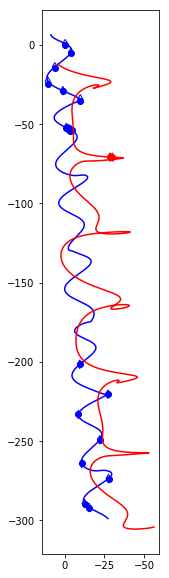

paremeters weighted by chi^2 with uncertainties from the fit
parallax 7.2161961311502285 0.12084890120349587
pmra -2.465918288411708 0.023911995438136983
pmdec -26.796675593594937 0.03510718545045903
accra 0.0 0.0
accdec 0.0 0.0
ra0 246.64239140300478 1.5951521179195048e-07
dec0 -24.391230930641285 1.3320155167653566e-07
eccentricity 0.7335834712327133 0.0965248490814974
period 1.735253012153577 0.005216653898386818
omega 104.20608609859804 30.85542517417801
semimajor axis 1 0.4680836082312806 0.07790514501805315
semimajor axis 2 2.7701197812066147 0.03834389477909412
mass ratio 0.20329684738015544 0.03045976827893621
inclination 147.80502831067685 13.26253015079456
Omega 131.15114825894852 35.11603056260124
time of passage [2455888.53293127] 10.999887733212434
total mass 7.066849067449299 0.8663334463059498
mass1 5.872221329746936 0.5703739295177951
mass2 1.1946277377023633 0.29595951678815474
 
paremeters from scatter
parallax 7.216646936223452 0.029148926914395513
pmra -2.4654037307

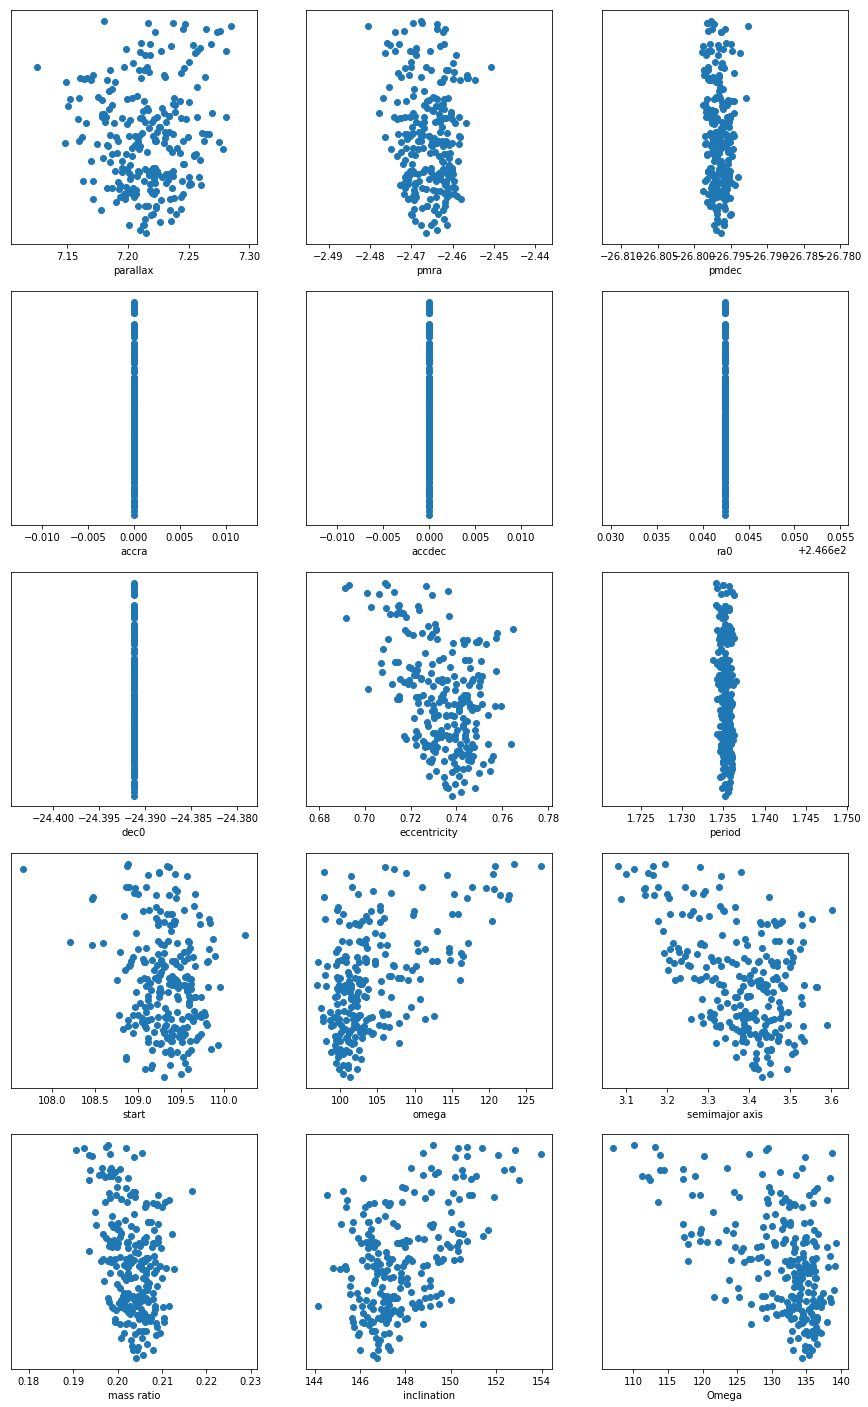

In [376]:
data=loaddata(0,1,skipepoch=[7,9,11,31,33, 22,23,24,25,26,27,28,29,30,35],fixdec=True)
#bestfit=rungrid(data,acceleration=False,startperiod=1,stopperiod=2,ran=10000,savepath='s1-old.pickle')
bestfit=pickle.load(open('s1-old.pickle',"rb"))
plotbest(data,bestfit)
result,error=outputsummaryfromfit(bestfit,toprint=True,upto=1.05)
sresult,serror=outputsummaryfromscatter(bestfit,toprint=True,upto=1.05)
examine(bestfit,upto=1.05)


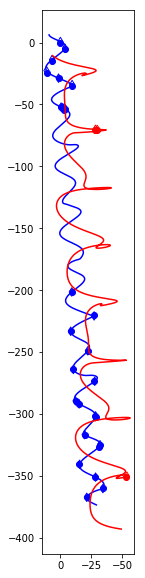

paremeters weighted by chi^2 with uncertainties from the fit
parallax 7.3780155622305195 0.07841109404065379
pmra -2.493254855413564 0.017879489413234046
pmdec -26.790891808947258 0.03131470504519038
accra 0.0 0.0
accdec 0.0 0.0
ra0 246.64239145341213 1.187468587221541e-07
dec0 -24.391230891791302 1.2758389627213414e-07
eccentricity 0.6903220299780168 0.07990815128418356
period 1.7346697116483742 0.004874892838269704
omega 117.58399239127675 49.90738512172718
semimajor axis 1 0.4197765575168802 1.8096909009144848e-13
semimajor axis 2 2.531970629864981 2.877971901909133e-07
mass ratio 0.1987397992013646 0.024177320406696966
inclination 156.17455393041976 12.78454747959401
Omega 120.04852035356444 51.83782903303957
time of passage [2457795.52489073] 12.47690064526846
total mass 5.39475643698616 0.08275987051849852
mass1 4.500352191424898 -0.02169674130462326
mass2 0.8944042455612624 0.10445661182312178
 
paremeters from scatter
parallax 7.37845957513736 0.012936603671164648
pmra -2.49328

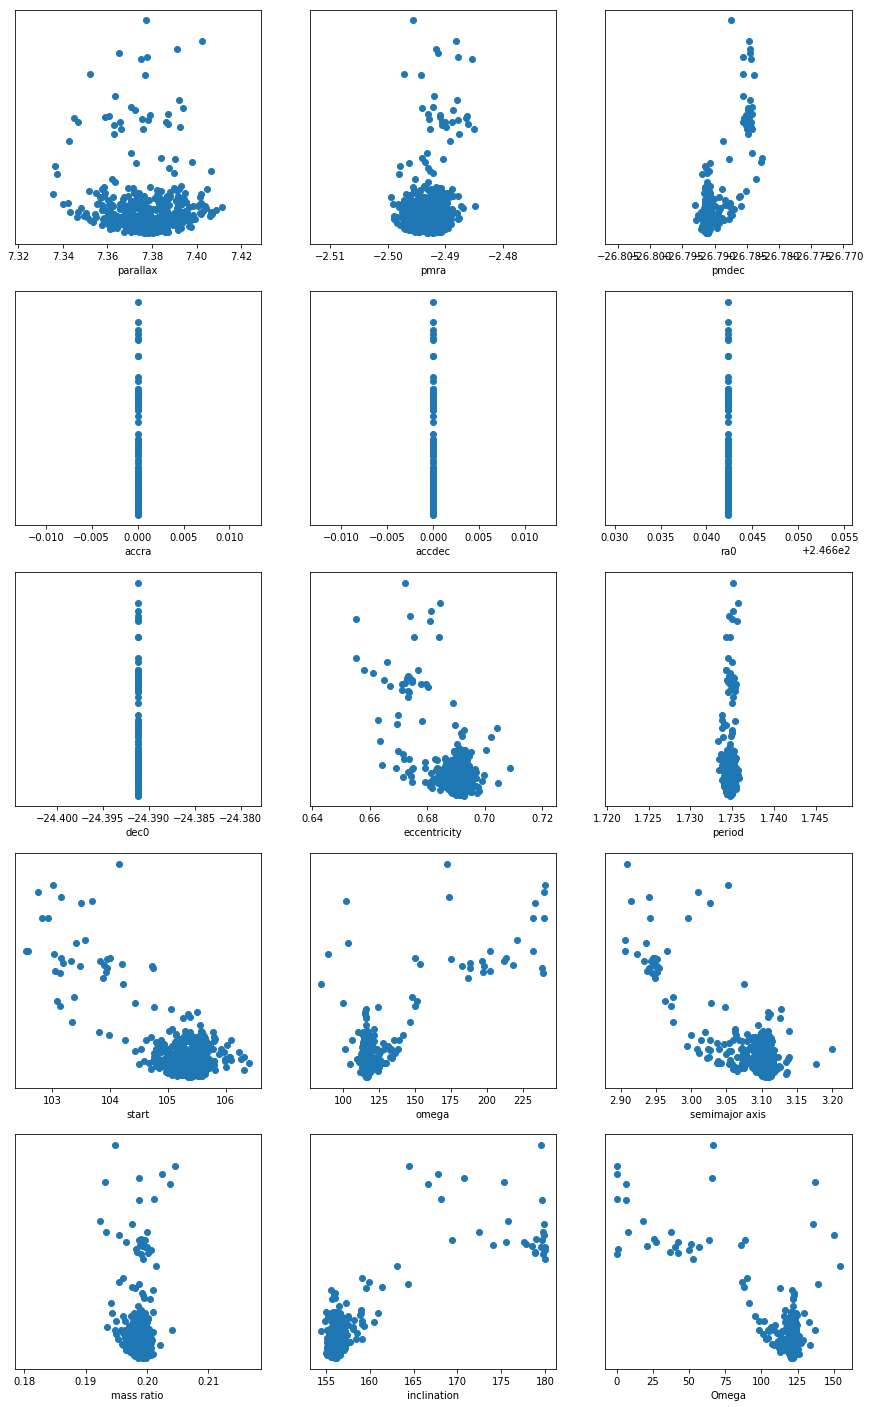

In [351]:
data=loaddata(0,1,skipepoch=[7,9,11,31,33],fixdec=True)
#bestfit=rungrid(data,acceleration=True,startperiod=1,stopperiod=2,ran=10000,savepath='s1-new.pickle')
bestfit=pickle.load(open('s1-new.pickle',"rb"))
plotbest(data,bestfit)
result,error=outputsummaryfromfit(bestfit,toprint=True,upto=1.05)
sresult,serror=outputsummaryfromscatter(bestfit,toprint=True,upto=1.05)
examine(bestfit,upto=1.2)


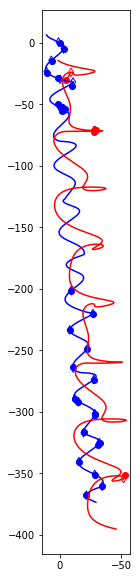

paremeters weighted by chi^2 with uncertainties from the fit
parallax 7.408111304161311 0.28315823255194617
pmra -2.510547496080351 0.059928995107722295
pmdec -26.78962544908681 0.11109654959604312
accra 0.0 0.0
accdec 0.0 0.0
ra0 246.64239159277233 4.3739434348063604e-07
dec0 -24.391230998767924 4.3985450628266373e-07
eccentricity 0.6786324917847597 0.281162976913762
period 1.757523175754513 0.01890624378177397
omega 149.80081824383066 569.4685021006838
semimajor axis 1 0.4130687889226804 4.2587286961205944e-13
semimajor axis 2 2.4300372816289264 4.6289621963177736e-07
mass ratio 0.20490705501583772 0.09073884828940297
inclination 152.49953256822553 395.9543866563605
Omega 76.47240526967065 560.4952026601309
time of passage [2458422.50840774] 45.04285569286497
total mass 4.650342319820852 1.9760086895149185
mass1 3.8603709065536695 1.3500670243243384
mass2 0.7899714132671816 0.6259416651905801
 
paremeters from scatter
parallax 7.4096738252103425 0.04326358149132784
pmra -2.5098868257

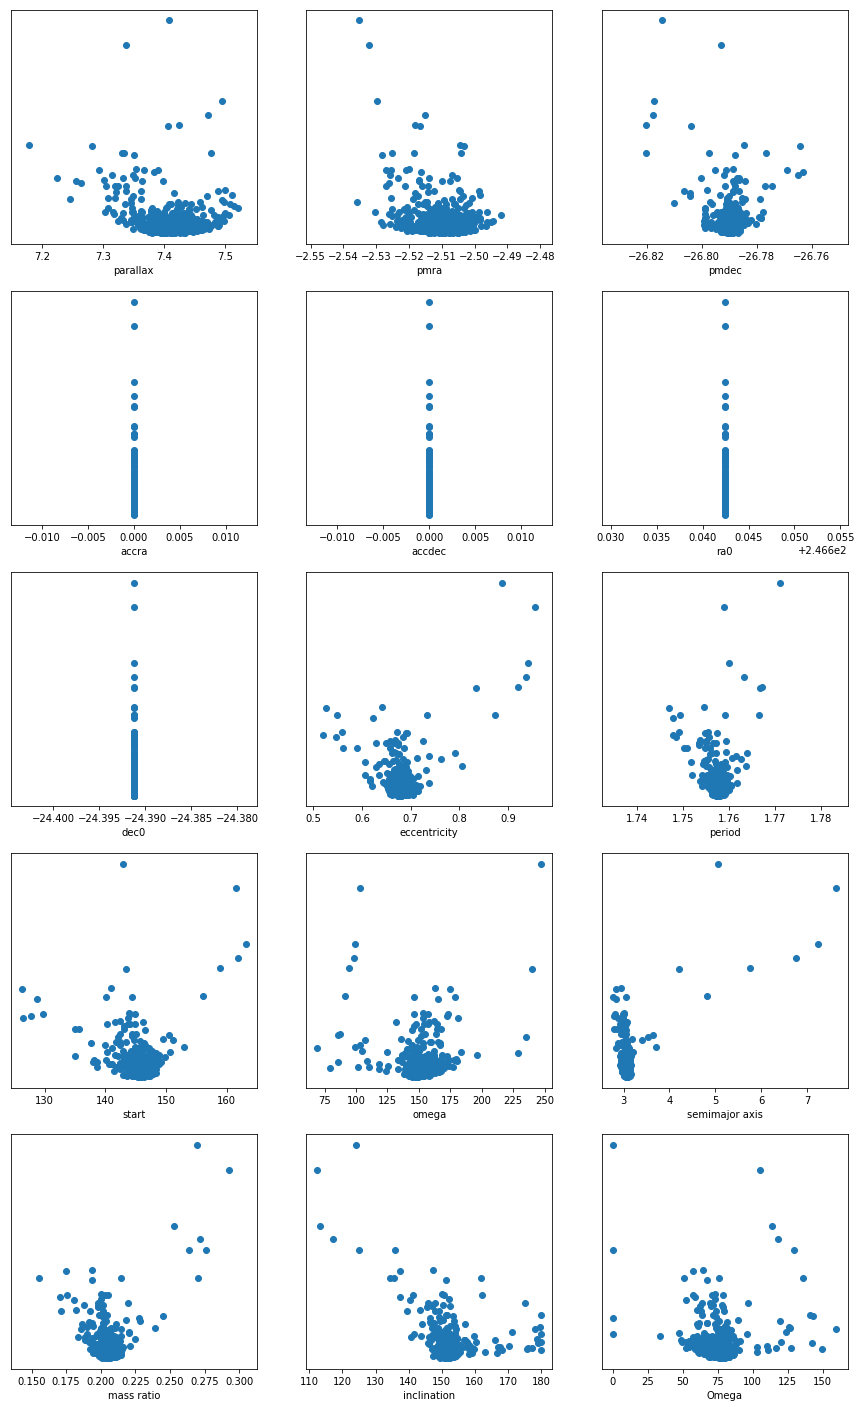

In [352]:
data=loaddata(0,1,fixdec=True)
#bestfit=rungrid(data,acceleration=False,startperiod=1,stopperiod=2,ran=10000,savepath='s1-newf.pickle')
bestfit=pickle.load(open('s1-newf.pickle',"rb"))
plotbest(data,bestfit)
result,error=outputsummaryfromfit(bestfit,toprint=True,upto=1.05)
sresult,serror=outputsummaryfromscatter(bestfit,toprint=True,upto=1.05)
examine(bestfit,upto=1.2)


In [ ]:
data=loaddata(0,1,skipepoch=[7,9,11],fixdec=True)
bestfit=rungrid(data,acceleration=False,startperiod=1,stopperiod=2,ran=1000,ratio=0.2)
plotbest(data,bestfit)
result,error=outputsummaryfromfit(bestfit,toprint=True,upto=1.05)
sresult,serror=outputsummaryfromscatter(bestfit,toprint=True,upto=1.05)
examine(bestfit,upto=1.05)


0 1000


/Users/mkounkel/research/distance/ep10/mpfit3.py:2266: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


100 1000
